# Userguide for the opern-source library SPFlow

SPFlow is an open-source functional-oriented Python package for Probabilistic Circuits (PCs) with ready-to-use implementations for Sum-Product Networks (SPNs). PCs are a class of powerful deep probabilistic models - expressible as directed acyclic graphs - that allow for tractable querying. This library provides routines for creating, learning, manipulating and interacting with PCs and is highly extensible and customizable.

## Create Toy Dataset

To demonstrate and visualize the main features of the library, we first create a 2D toy dataset with three Gaussian clusters, corresponding to labels 0, 1, and 2.
The dataset is created with an imbalance. Therefore, class 0 has 200 datapoints, class 1 400 datapoints and class 2 600 datapoints, for a total of 1,200 data points.

Dataset successfully created.
Shape of dataset: torch.Size([1200, 2])
Shape of labels: torch.Size([1200])
First 5 samples:
tensor([[ 2.6633, -2.9716],
        [ 0.7676,  2.1950],
        [-2.0958, -2.5638],
        [-2.6759, -2.4448],
        [ 2.9349, -2.0068]])
Corresponding labels:
tensor([2, 0, 1, 1, 2])
1
(1200, 2)
Toy Data


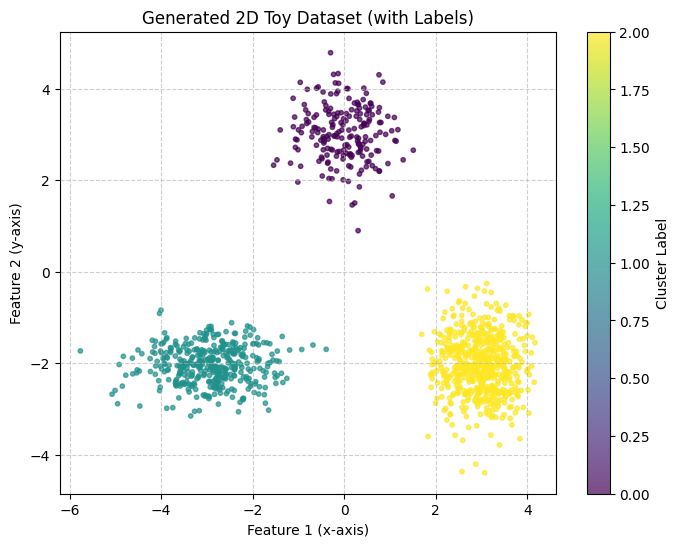

In [1]:
import torch
import matplotlib.pyplot as plt

# --- 1. Define the parameters for our dataset ---

n_points_per_cluster = 200

means = torch.tensor([
    [0.0, 3.0],   # Cluster 0
    [-3.0, -2.0], # Cluster 1
    [3.0, -2.0]   # Cluster 2
])

stds = torch.tensor([
    [0.6, 0.6],
    [0.8, 0.4],
    [0.5, 0.7]
])

# --- 2. Generate the data and labels ---

all_clusters = []
all_labels = []

for i in range(means.shape[0]):
    samples = (torch.randn(n_points_per_cluster*(i+1), 2) * stds[i]) + means[i]
    labels = torch.full((n_points_per_cluster*(i+1),), i, dtype=torch.long)  # label = cluster index
    all_clusters.append(samples)
    all_labels.append(labels)

# Concatenate all data and labels
dataset = torch.cat(all_clusters)
labels = torch.cat(all_labels)

# --- 3. Shuffle dataset and labels together ---

shuffled_indices = torch.randperm(dataset.shape[0])
dataset = dataset[shuffled_indices]
labels = labels[shuffled_indices]

# --- 4. Display some info ---

print("Dataset successfully created.")
print(f"Shape of dataset: {dataset.shape}")
print(f"Shape of labels: {labels.shape}")
print("First 5 samples:")
print(dataset[:5])
print("Corresponding labels:")
print(labels[:5])

# --- 5. Visualize the labeled dataset ---

data_np = dataset.cpu().numpy()
labels_np = labels.cpu().numpy()

def plot_scatter(data_list, title=None, labels=None, label_list=None):
    colors=["blue", "red", "yellow", "green"]
    plt.figure(figsize=(8, 6))
    for idx, data in enumerate(data_list):
        print(len(data_list))
        print(data.shape)
        print(label_list[idx])
        if labels is not None and len(data_list)==1:
            plt.scatter(data[:, 0], data[:, 1], c=labels, cmap="viridis", s=10, alpha=0.7)
            plt.colorbar(label='Cluster Label')
        else:
            plt.scatter(data[:, 0], data[:, 1], c=colors[idx], s=10, alpha=0.7, label=label_list[idx])
            plt.legend()
            
    plt.title(title)
    plt.xlabel('Feature 1 (x-axis)')
    plt.ylabel('Feature 2 (y-axis)')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.axis('equal')
    #plt.colorbar(label='Cluster Label')
    
    plt.show()
    
plot_scatter([data_np], title='Generated 2D Toy Dataset (with Labels)', labels=labels_np, label_list=['Toy Data'])



## Model Configuration
The circuits you create with this library are modular. 

All modules share the same base structure. Each module is defined by its number of output features and output channels. You can think of output features as the number of nodes with different scopes in one layer. You can think of output channels as how many times a node with the same scope is repeated in a layer. This structure lets you define simple nodes (with a shape of (1, 1)), node vectors along the feature (N, 1) or channel (1, M) dimension, or full leaf layers (N, M). In many cases, using layers instead of single nodes is much faster and more memory-efficient.

Each module also has an input attribute that points to its input module. This lets you stack modules together in any order. 

Below, we will build a simple Sum-Product Network by stacking leaf, product, and sum layers.

In [2]:
from spflow.modules.leaf import Normal
from spflow.modules import Sum
from spflow.modules import Product
from spflow.meta.data import Scope
from IPython.display import SVG, display

scope = Scope([0,1])

leaf_layer = Normal(scope=scope, out_channels=6)
product_layer = Product(inputs=leaf_layer)
spn = Sum(inputs=product_layer, out_channels=1)
spn

Sum(
  D=1, C=1, R=None, weights=(1, 6, 1)
  (inputs): Product(
    D=1, C=6, R=None
    (inputs): Normal(
      D=2, C=6, R=None
      (distribution): Normal()
    )
  )
)

Below is a visualization of the SPN defined above.
The number of output channels of a sum or leaf layer is equivalent to the number of nodes in that layer.
The number of nodes in a product layer is derived from the number of nodes in its input.

In [3]:
display(SVG(filename='StandardSPN.svg'))

Next, we can train the SPN, for example, using gradient descent.
The library already provides a method for training an SPN with gradient descent.
To do this, simply pass the module you want to train and the training parameters such as the number of epochs, learning rate, etc.


In [4]:
from spflow.learn import train_gradient_descent
from torch.utils.data import DataLoader, TensorDataset
import logging
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s [%(levelname)s] %(name)s: %(message)s"
)

train_dataset = TensorDataset(dataset)
dataloader = DataLoader(train_dataset, batch_size=10)
train_gradient_descent(spn, dataloader, epochs=10, lr=0.1, verbose=True)

2025-11-05 12:28:52,626 [INFO] spflow.learn.gradient_descent: Epoch [0/10]: Loss: 33.724456787109375


Time taken for epoch:  0.536144495010376


2025-11-05 12:28:52,964 [INFO] spflow.learn.gradient_descent: Epoch [1/10]: Loss: 33.57545852661133


Time taken for epoch:  0.33699560165405273


2025-11-05 12:28:53,286 [INFO] spflow.learn.gradient_descent: Epoch [2/10]: Loss: 26.797142028808594


Time taken for epoch:  0.32000017166137695


2025-11-05 12:28:53,627 [INFO] spflow.learn.gradient_descent: Epoch [3/10]: Loss: 25.10628318786621


Time taken for epoch:  0.33899974822998047


2025-11-05 12:28:53,960 [INFO] spflow.learn.gradient_descent: Epoch [4/10]: Loss: 25.561941146850586


Time taken for epoch:  0.3319995403289795


2025-11-05 12:28:54,299 [INFO] spflow.learn.gradient_descent: Epoch [5/10]: Loss: 24.194543838500977


Time taken for epoch:  0.33699989318847656


2025-11-05 12:28:54,744 [INFO] spflow.learn.gradient_descent: Epoch [6/10]: Loss: 24.13068962097168


Time taken for epoch:  0.4420013427734375


2025-11-05 12:28:55,060 [INFO] spflow.learn.gradient_descent: Epoch [7/10]: Loss: 23.99927520751953


Time taken for epoch:  0.3139955997467041


2025-11-05 12:28:55,420 [INFO] spflow.learn.gradient_descent: Epoch [8/10]: Loss: 23.906753540039062


Time taken for epoch:  0.35900044441223145


2025-11-05 12:28:55,793 [INFO] spflow.learn.gradient_descent: Epoch [9/10]: Loss: 23.844402313232422


Time taken for epoch:  0.36999988555908203


Once the SPN is trained, we can perform queries such as inference and sampling.
SPFlow uses internal dispatching so that a single query function can work across all module types.
For example, the log_likelihood method shown below can be used for every SPN model encountered throughout this guide.

In [5]:
from spflow import log_likelihood

ll = log_likelihood(spn, dataset)
ll

tensor([[[-2.7203]],

        [[-4.3540]],

        [[-3.1085]],

        ...,

        [[-1.5362]],

        [[-2.5431]],

        [[-1.6005]]], grad_fn=<ViewBackward0>)

Finally, we can visualize the training results on our toy dataset.

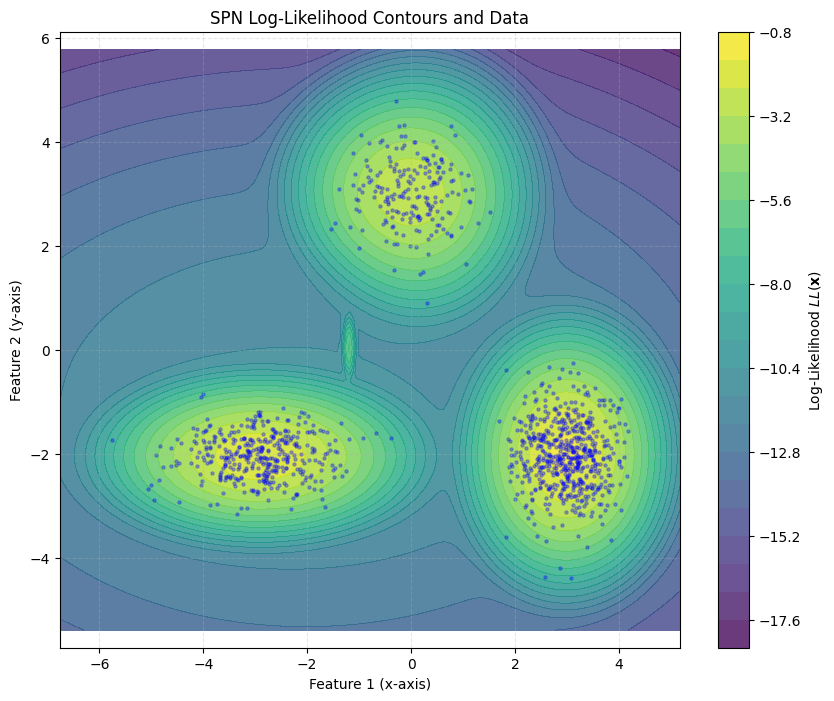

In [6]:
import numpy as np
data_np = dataset.cpu().numpy()
def plot_contour(data, spn):
    # Define the boundaries of the plot with a small padding
    x_min, x_max = data_np[:, 0].min() - 1, data_np[:, 0].max() + 1
    y_min, y_max = data_np[:, 1].min() - 1, data_np[:, 1].max() + 1
    
    # Create a grid of points
    grid_resolution = 200
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, grid_resolution),
                         np.linspace(y_min, y_max, grid_resolution))
    
    # Stack the grid points into a format our function can accept: [n_points, 2]
    grid_points = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)
    ll = log_likelihood(spn, grid_points)
    # Reshape the LL values to match the grid shape for plotting
    Z = ll.detach().cpu().numpy().reshape(xx.shape)
    
    
    # --- 6. Visualize the Data and Log-Likelihood Contours ---
    
    plt.figure(figsize=(10, 8))
    
    # Plot the filled contour map of the log-likelihood
    # Higher values (brighter colors) mean the model thinks data is more likely there
    contour = plt.contourf(xx, yy, Z, levels=20, cmap='viridis', alpha=0.8)
    
    # Add a color bar to show the LL scale
    plt.colorbar(contour, label='Log-Likelihood $LL(\mathbf{x})$')
    
    # Overlay the scatter plot of the actual data points
    # We make them semi-transparent and small to see the density and contours
    plt.scatter(data_np[:, 0], data_np[:, 1], s=5, alpha=0.3, c='blue')
    
    # Add titles and labels
    plt.title('SPN Log-Likelihood Contours and Data')
    plt.xlabel('Feature 1 (x-axis)')
    plt.ylabel('Feature 2 (y-axis)')
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.axis('equal') # Ensures the scaling is the same on both axes
    plt.show()
plot_contour(data_np, spn)

## Automatic Model creation
Besides creating an SPN manually by stacking layers, it is also possible to use algorithms to automatically construct the SPN architecture. This can make it easier to start using SPNs.

###  Rat-SPN
The Rat-SPN algorithm builds a deep network structure by recursively partitioning the features (variables) into random subsets and alternating between sum and product layers.
Below, we set up a Rat-SPN by defining its structure and parameters.

In [7]:
from spflow.modules.rat.rat_spn import RatSPN
depth = 1
n_region_nodes = 3
num_leaves = 2
num_repetitions = 2
n_root_nodes = 1
num_feature = 2

scope = Scope(list(range(0, num_feature)))

rat_leaf_layer = Normal(scope=scope, out_channels=num_leaves, num_repetitions=num_repetitions)
rat = RatSPN(
    leaf_modules=[rat_leaf_layer],
    n_root_nodes=n_root_nodes,
    n_region_nodes=n_region_nodes,
    num_repetitions=num_repetitions,
    depth=depth,
    outer_product=True,
    split_halves=True,
)
rat

RatSPN(
  D=1, C=1, R=2
  (root_node): MixingLayer(
    D=1, C=1, R=2, weights=(1, 2, 1)
    (inputs): Sum(
      D=1, C=1, R=2, weights=(1, 4, 1, 2)
      (inputs): OuterProduct(
        D=1, C=4, R=2
        (inputs): ModuleList(
          (0): SplitHalves(
            D=2, C=2, R=2, dim=1
            (inputs): ModuleList(
              (0): Factorize(
                D=2, C=2, R=2
                (inputs): ModuleList(
                  (0): Normal(
                    D=2, C=2, R=2
                    (distribution): Normal()
                  )
                )
              )
            )
          )
        )
      )
    )
  )
)

Here is a visualization of the architecture we just created.

In [8]:
display(SVG(filename='Rat_SPN.svg'))

In [9]:
ll = log_likelihood(rat, dataset)
ll

tensor([[[-11.5472]],

        [[ -6.8766]],

        [[-10.0867]],

        ...,

        [[-10.8761]],

        [[-16.1639]],

        [[-13.6323]]], grad_fn=<ViewBackward0>)

We can again train this model using the provided gradient descent method. 

In [10]:
train_gradient_descent(rat, dataloader, epochs=20, lr=0.1)

Time taken for epoch:  0.5540025234222412
Time taken for epoch:  0.4399995803833008
Time taken for epoch:  0.6160082817077637
Time taken for epoch:  0.5182993412017822
Time taken for epoch:  0.45302820205688477
Time taken for epoch:  0.4520728588104248
Time taken for epoch:  0.5955023765563965
Time taken for epoch:  0.43700218200683594
Time taken for epoch:  0.45099663734436035
Time taken for epoch:  0.4500000476837158
Time taken for epoch:  0.4530003070831299
Time taken for epoch:  0.5010004043579102
Time taken for epoch:  0.475999116897583
Time taken for epoch:  0.45400023460388184
Time taken for epoch:  0.4550001621246338
Time taken for epoch:  0.4529993534088135
Time taken for epoch:  0.4530007839202881
Time taken for epoch:  0.45999884605407715
Time taken for epoch:  0.4510009288787842
Time taken for epoch:  0.45599961280822754


To verify that the training worked properly, we can visualize the log-likelihoods of the trained model.

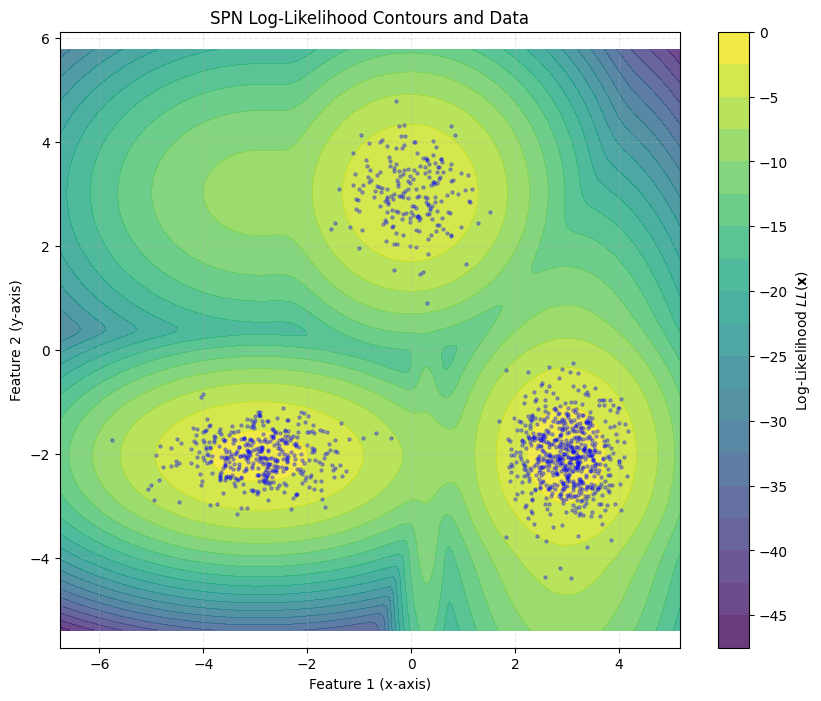

In [11]:
import numpy as np
data_np = dataset.cpu().numpy()
plot_contour(data_np, rat)

Of course, computing log-likelihoods is not the only thing the model can do.
Below is a visualization of samples drawn from the trained Rat-SPN.

2
(1200, 2)
Original Data
2
torch.Size([1500, 2])
Samples


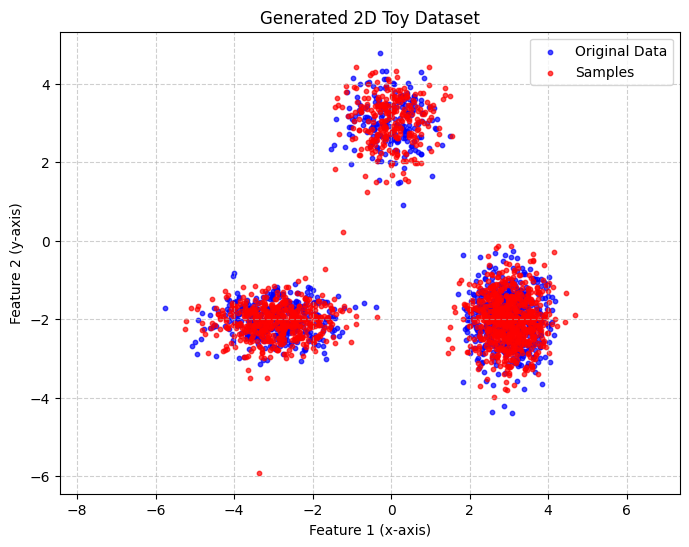

In [12]:
from spflow import sample

samples = sample(spn, 1500)
plot_scatter([data_np,samples], title= 'Generated 2D Toy Dataset', label_list=['Original Data', 'Samples'])


Up to now, we have focused only on generation, without considering the labels of the training instances.
Next, we will train a second Rat-SPN for classification.

In [13]:
import logging
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s [%(levelname)s] %(name)s: %(message)s"
)

depth = 1
n_region_nodes = 1
num_leaves = 10
num_repetitions = 1
n_root_nodes = 3
num_feature = 2

scope = Scope(list(range(0, num_feature)))

rat_leaf_layer = Normal(scope=scope, out_channels=num_leaves, num_repetitions=num_repetitions)
rat = RatSPN(
    leaf_modules=[rat_leaf_layer],
    n_root_nodes=n_root_nodes,
    n_region_nodes=n_region_nodes,
    num_repetitions=num_repetitions,
    depth=depth,
    outer_product=True,
    split_halves=True,
)
#print(dataset.size)
train_dataset = TensorDataset(dataset, labels)

dataloader_with_labels = DataLoader(train_dataset, batch_size=10)

train_gradient_descent(rat.root_node.inputs, dataloader_with_labels, epochs=100, lr=0.001, is_classification=True, verbose=True)



2025-11-05 12:29:07,956 [INFO] spflow.learn.gradient_descent: Epoch [0/100]: Loss: 6.380537986755371


Time taken for epoch:  0.6148569583892822
Accuracy: 18.0


2025-11-05 12:29:08,531 [INFO] spflow.learn.gradient_descent: Epoch [1/100]: Loss: 5.666635513305664


Time taken for epoch:  0.5730009078979492
Accuracy: 43.5


2025-11-05 12:29:09,108 [INFO] spflow.learn.gradient_descent: Epoch [2/100]: Loss: 5.054636001586914


Time taken for epoch:  0.5750026702880859
Accuracy: 70.75


2025-11-05 12:29:09,729 [INFO] spflow.learn.gradient_descent: Epoch [3/100]: Loss: 4.54858922958374


Time taken for epoch:  0.6199538707733154
Accuracy: 81.58333333333333


2025-11-05 12:29:10,250 [INFO] spflow.learn.gradient_descent: Epoch [4/100]: Loss: 4.153425216674805


Time taken for epoch:  0.5199997425079346
Accuracy: 85.75


2025-11-05 12:29:10,720 [INFO] spflow.learn.gradient_descent: Epoch [5/100]: Loss: 3.839369297027588


Time taken for epoch:  0.467998743057251
Accuracy: 90.91666666666667


2025-11-05 12:29:11,168 [INFO] spflow.learn.gradient_descent: Epoch [6/100]: Loss: 3.5825576782226562


Time taken for epoch:  0.44600582122802734
Accuracy: 97.41666666666667


2025-11-05 12:29:11,602 [INFO] spflow.learn.gradient_descent: Epoch [7/100]: Loss: 3.365281581878662


Time taken for epoch:  0.43199992179870605
Accuracy: 98.83333333333333


2025-11-05 12:29:12,011 [INFO] spflow.learn.gradient_descent: Epoch [8/100]: Loss: 3.176100730895996


Time taken for epoch:  0.40800046920776367
Accuracy: 99.83333333333333


2025-11-05 12:29:12,407 [INFO] spflow.learn.gradient_descent: Epoch [9/100]: Loss: 3.007909059524536


Time taken for epoch:  0.3950014114379883
Accuracy: 100.0


2025-11-05 12:29:12,789 [INFO] spflow.learn.gradient_descent: Epoch [10/100]: Loss: 2.856362819671631


Time taken for epoch:  0.3809964656829834
Accuracy: 100.0


2025-11-05 12:29:13,315 [INFO] spflow.learn.gradient_descent: Epoch [11/100]: Loss: 2.718904972076416


Time taken for epoch:  0.5240018367767334
Accuracy: 100.0


2025-11-05 12:29:13,716 [INFO] spflow.learn.gradient_descent: Epoch [12/100]: Loss: 2.5938000679016113


Time taken for epoch:  0.3989999294281006
Accuracy: 100.0


2025-11-05 12:29:14,018 [INFO] spflow.learn.gradient_descent: Epoch [13/100]: Loss: 2.479464292526245


Time taken for epoch:  0.30100202560424805
Accuracy: 100.0


2025-11-05 12:29:14,405 [INFO] spflow.learn.gradient_descent: Epoch [14/100]: Loss: 2.3745064735412598


Time taken for epoch:  0.38599610328674316
Accuracy: 100.0


2025-11-05 12:29:14,697 [INFO] spflow.learn.gradient_descent: Epoch [15/100]: Loss: 2.2780590057373047


Time taken for epoch:  0.2909979820251465
Accuracy: 100.0


2025-11-05 12:29:14,979 [INFO] spflow.learn.gradient_descent: Epoch [16/100]: Loss: 2.1898839473724365


Time taken for epoch:  0.28099775314331055
Accuracy: 100.0


2025-11-05 12:29:15,340 [INFO] spflow.learn.gradient_descent: Epoch [17/100]: Loss: 2.1101276874542236


Time taken for epoch:  0.35899925231933594
Accuracy: 100.0


2025-11-05 12:29:15,705 [INFO] spflow.learn.gradient_descent: Epoch [18/100]: Loss: 2.0388944149017334


Time taken for epoch:  0.3639986515045166
Accuracy: 100.0


2025-11-05 12:29:16,008 [INFO] spflow.learn.gradient_descent: Epoch [19/100]: Loss: 1.9759019613265991


Time taken for epoch:  0.3019983768463135
Accuracy: 100.0


2025-11-05 12:29:16,287 [INFO] spflow.learn.gradient_descent: Epoch [20/100]: Loss: 1.9204139709472656


Time taken for epoch:  0.27699899673461914
Accuracy: 100.0


2025-11-05 12:29:16,602 [INFO] spflow.learn.gradient_descent: Epoch [21/100]: Loss: 1.8714298009872437


Time taken for epoch:  0.31400489807128906
Accuracy: 100.0


2025-11-05 12:29:16,948 [INFO] spflow.learn.gradient_descent: Epoch [22/100]: Loss: 1.8279368877410889


Time taken for epoch:  0.34400010108947754
Accuracy: 100.0


2025-11-05 12:29:17,340 [INFO] spflow.learn.gradient_descent: Epoch [23/100]: Loss: 1.7890777587890625


Time taken for epoch:  0.3920016288757324
Accuracy: 100.0


2025-11-05 12:29:17,632 [INFO] spflow.learn.gradient_descent: Epoch [24/100]: Loss: 1.7541996240615845


Time taken for epoch:  0.2910025119781494
Accuracy: 100.0


2025-11-05 12:29:17,980 [INFO] spflow.learn.gradient_descent: Epoch [25/100]: Loss: 1.7228349447250366


Time taken for epoch:  0.3469991683959961
Accuracy: 100.0


2025-11-05 12:29:18,257 [INFO] spflow.learn.gradient_descent: Epoch [26/100]: Loss: 1.6946556568145752


Time taken for epoch:  0.27499890327453613
Accuracy: 100.0


2025-11-05 12:29:18,533 [INFO] spflow.learn.gradient_descent: Epoch [27/100]: Loss: 1.6694238185882568


Time taken for epoch:  0.2760000228881836
Accuracy: 99.91666666666667


2025-11-05 12:29:18,814 [INFO] spflow.learn.gradient_descent: Epoch [28/100]: Loss: 1.6469539403915405


Time taken for epoch:  0.2799983024597168
Accuracy: 99.91666666666667


2025-11-05 12:29:19,104 [INFO] spflow.learn.gradient_descent: Epoch [29/100]: Loss: 1.6270778179168701


Time taken for epoch:  0.2890007495880127
Accuracy: 99.91666666666667


2025-11-05 12:29:19,452 [INFO] spflow.learn.gradient_descent: Epoch [30/100]: Loss: 1.609622597694397


Time taken for epoch:  0.34600210189819336
Accuracy: 99.91666666666667


2025-11-05 12:29:19,743 [INFO] spflow.learn.gradient_descent: Epoch [31/100]: Loss: 1.5943963527679443


Time taken for epoch:  0.28899693489074707
Accuracy: 99.91666666666667


2025-11-05 12:29:20,020 [INFO] spflow.learn.gradient_descent: Epoch [32/100]: Loss: 1.5811896324157715


Time taken for epoch:  0.2759997844696045
Accuracy: 99.91666666666667


2025-11-05 12:29:20,300 [INFO] spflow.learn.gradient_descent: Epoch [33/100]: Loss: 1.5697776079177856


Time taken for epoch:  0.2799999713897705
Accuracy: 99.91666666666667


2025-11-05 12:29:20,574 [INFO] spflow.learn.gradient_descent: Epoch [34/100]: Loss: 1.5599488019943237


Time taken for epoch:  0.2729990482330322
Accuracy: 99.91666666666667


2025-11-05 12:29:20,856 [INFO] spflow.learn.gradient_descent: Epoch [35/100]: Loss: 1.5514706373214722


Time taken for epoch:  0.28099918365478516
Accuracy: 99.91666666666667


2025-11-05 12:29:21,147 [INFO] spflow.learn.gradient_descent: Epoch [36/100]: Loss: 1.5441237688064575


Time taken for epoch:  0.2890021800994873
Accuracy: 99.91666666666667


2025-11-05 12:29:21,469 [INFO] spflow.learn.gradient_descent: Epoch [37/100]: Loss: 1.5377479791641235


Time taken for epoch:  0.32100343704223633
Accuracy: 99.91666666666667


2025-11-05 12:29:21,879 [INFO] spflow.learn.gradient_descent: Epoch [38/100]: Loss: 1.5321930646896362


Time taken for epoch:  0.4089944362640381
Accuracy: 99.91666666666667


2025-11-05 12:29:22,161 [INFO] spflow.learn.gradient_descent: Epoch [39/100]: Loss: 1.5273287296295166


Time taken for epoch:  0.28099751472473145
Accuracy: 99.91666666666667


2025-11-05 12:29:22,448 [INFO] spflow.learn.gradient_descent: Epoch [40/100]: Loss: 1.5230443477630615


Time taken for epoch:  0.2850034236907959
Accuracy: 99.91666666666667


2025-11-05 12:29:22,728 [INFO] spflow.learn.gradient_descent: Epoch [41/100]: Loss: 1.5192500352859497


Time taken for epoch:  0.279998779296875
Accuracy: 99.91666666666667


2025-11-05 12:29:23,010 [INFO] spflow.learn.gradient_descent: Epoch [42/100]: Loss: 1.5158692598342896


Time taken for epoch:  0.2799997329711914
Accuracy: 99.91666666666667


2025-11-05 12:29:23,348 [INFO] spflow.learn.gradient_descent: Epoch [43/100]: Loss: 1.5128425359725952


Time taken for epoch:  0.3370022773742676
Accuracy: 99.91666666666667


2025-11-05 12:29:23,679 [INFO] spflow.learn.gradient_descent: Epoch [44/100]: Loss: 1.5101184844970703


Time taken for epoch:  0.32999753952026367
Accuracy: 99.91666666666667


2025-11-05 12:29:23,964 [INFO] spflow.learn.gradient_descent: Epoch [45/100]: Loss: 1.5076568126678467


Time taken for epoch:  0.28400301933288574
Accuracy: 99.91666666666667


2025-11-05 12:29:24,243 [INFO] spflow.learn.gradient_descent: Epoch [46/100]: Loss: 1.5054223537445068


Time taken for epoch:  0.2780025005340576
Accuracy: 99.91666666666667


2025-11-05 12:29:24,526 [INFO] spflow.learn.gradient_descent: Epoch [47/100]: Loss: 1.5033855438232422


Time taken for epoch:  0.28099751472473145
Accuracy: 100.0


2025-11-05 12:29:24,884 [INFO] spflow.learn.gradient_descent: Epoch [48/100]: Loss: 1.5015207529067993


Time taken for epoch:  0.3580031394958496
Accuracy: 100.0


2025-11-05 12:29:25,166 [INFO] spflow.learn.gradient_descent: Epoch [49/100]: Loss: 1.4998060464859009


Time taken for epoch:  0.28099727630615234
Accuracy: 100.0


2025-11-05 12:29:25,518 [INFO] spflow.learn.gradient_descent: Epoch [50/100]: Loss: 1.4995789527893066


Time taken for epoch:  0.3510003089904785
Accuracy: 100.0


2025-11-05 12:29:25,793 [INFO] spflow.learn.gradient_descent: Epoch [51/100]: Loss: 1.4993469715118408


Time taken for epoch:  0.27300000190734863
Accuracy: 100.0


2025-11-05 12:29:26,082 [INFO] spflow.learn.gradient_descent: Epoch [52/100]: Loss: 1.4991137981414795


Time taken for epoch:  0.28751444816589355
Accuracy: 100.0


2025-11-05 12:29:26,498 [INFO] spflow.learn.gradient_descent: Epoch [53/100]: Loss: 1.4988791942596436


Time taken for epoch:  0.41318607330322266
Accuracy: 100.0


2025-11-05 12:29:26,849 [INFO] spflow.learn.gradient_descent: Epoch [54/100]: Loss: 1.498642921447754


Time taken for epoch:  0.3489999771118164
Accuracy: 100.0


2025-11-05 12:29:27,132 [INFO] spflow.learn.gradient_descent: Epoch [55/100]: Loss: 1.4984047412872314


Time taken for epoch:  0.2819995880126953
Accuracy: 100.0


2025-11-05 12:29:27,409 [INFO] spflow.learn.gradient_descent: Epoch [56/100]: Loss: 1.4981640577316284


Time taken for epoch:  0.2759997844696045
Accuracy: 100.0


2025-11-05 12:29:27,683 [INFO] spflow.learn.gradient_descent: Epoch [57/100]: Loss: 1.4979220628738403


Time taken for epoch:  0.27399754524230957
Accuracy: 100.0


2025-11-05 12:29:27,967 [INFO] spflow.learn.gradient_descent: Epoch [58/100]: Loss: 1.4976775646209717


Time taken for epoch:  0.2819998264312744
Accuracy: 100.0


2025-11-05 12:29:28,248 [INFO] spflow.learn.gradient_descent: Epoch [59/100]: Loss: 1.497430443763733


Time taken for epoch:  0.27900171279907227
Accuracy: 100.0


2025-11-05 12:29:28,548 [INFO] spflow.learn.gradient_descent: Epoch [60/100]: Loss: 1.4971812963485718


Time taken for epoch:  0.298994779586792
Accuracy: 100.0


2025-11-05 12:29:28,828 [INFO] spflow.learn.gradient_descent: Epoch [61/100]: Loss: 1.4969303607940674


Time taken for epoch:  0.27899837493896484
Accuracy: 100.0


2025-11-05 12:29:29,104 [INFO] spflow.learn.gradient_descent: Epoch [62/100]: Loss: 1.496677041053772


Time taken for epoch:  0.2740023136138916
Accuracy: 100.0


2025-11-05 12:29:29,382 [INFO] spflow.learn.gradient_descent: Epoch [63/100]: Loss: 1.4964218139648438


Time taken for epoch:  0.2779982089996338
Accuracy: 100.0


2025-11-05 12:29:29,665 [INFO] spflow.learn.gradient_descent: Epoch [64/100]: Loss: 1.4961645603179932


Time taken for epoch:  0.28099608421325684
Accuracy: 100.0


2025-11-05 12:29:29,934 [INFO] spflow.learn.gradient_descent: Epoch [65/100]: Loss: 1.495905876159668


Time taken for epoch:  0.26800036430358887
Accuracy: 100.0


2025-11-05 12:29:30,208 [INFO] spflow.learn.gradient_descent: Epoch [66/100]: Loss: 1.49564528465271


Time taken for epoch:  0.2729990482330322
Accuracy: 100.0


2025-11-05 12:29:30,495 [INFO] spflow.learn.gradient_descent: Epoch [67/100]: Loss: 1.4953837394714355


Time taken for epoch:  0.28499627113342285
Accuracy: 100.0


2025-11-05 12:29:30,772 [INFO] spflow.learn.gradient_descent: Epoch [68/100]: Loss: 1.4951212406158447


Time taken for epoch:  0.2769954204559326
Accuracy: 100.0


2025-11-05 12:29:31,072 [INFO] spflow.learn.gradient_descent: Epoch [69/100]: Loss: 1.4948571920394897


Time taken for epoch:  0.2989993095397949
Accuracy: 100.0


2025-11-05 12:29:31,355 [INFO] spflow.learn.gradient_descent: Epoch [70/100]: Loss: 1.494592308998108


Time taken for epoch:  0.2820010185241699
Accuracy: 100.0


2025-11-05 12:29:31,639 [INFO] spflow.learn.gradient_descent: Epoch [71/100]: Loss: 1.4943270683288574


Time taken for epoch:  0.28299951553344727
Accuracy: 100.0


2025-11-05 12:29:31,920 [INFO] spflow.learn.gradient_descent: Epoch [72/100]: Loss: 1.4940617084503174


Time taken for epoch:  0.279998779296875
Accuracy: 100.0


2025-11-05 12:29:32,193 [INFO] spflow.learn.gradient_descent: Epoch [73/100]: Loss: 1.49379563331604


Time taken for epoch:  0.2709991931915283
Accuracy: 100.0


2025-11-05 12:29:32,558 [INFO] spflow.learn.gradient_descent: Epoch [74/100]: Loss: 1.493530035018921


Time taken for epoch:  0.3640015125274658
Accuracy: 100.0


2025-11-05 12:29:32,887 [INFO] spflow.learn.gradient_descent: Epoch [75/100]: Loss: 1.4935020208358765


Time taken for epoch:  0.3269994258880615
Accuracy: 100.0


2025-11-05 12:29:33,165 [INFO] spflow.learn.gradient_descent: Epoch [76/100]: Loss: 1.4934743642807007


Time taken for epoch:  0.27699804306030273
Accuracy: 100.0


2025-11-05 12:29:33,550 [INFO] spflow.learn.gradient_descent: Epoch [77/100]: Loss: 1.4934463500976562


Time taken for epoch:  0.3830106258392334
Accuracy: 100.0


2025-11-05 12:29:33,853 [INFO] spflow.learn.gradient_descent: Epoch [78/100]: Loss: 1.493417739868164


Time taken for epoch:  0.3019981384277344
Accuracy: 100.0


2025-11-05 12:29:34,130 [INFO] spflow.learn.gradient_descent: Epoch [79/100]: Loss: 1.4933881759643555


Time taken for epoch:  0.2759993076324463
Accuracy: 100.0


2025-11-05 12:29:34,412 [INFO] spflow.learn.gradient_descent: Epoch [80/100]: Loss: 1.4933592081069946


Time taken for epoch:  0.28099679946899414
Accuracy: 100.0


2025-11-05 12:29:34,746 [INFO] spflow.learn.gradient_descent: Epoch [81/100]: Loss: 1.493329644203186


Time taken for epoch:  0.33200550079345703
Accuracy: 100.0


2025-11-05 12:29:35,057 [INFO] spflow.learn.gradient_descent: Epoch [82/100]: Loss: 1.4932992458343506


Time taken for epoch:  0.30899882316589355
Accuracy: 100.0


2025-11-05 12:29:35,344 [INFO] spflow.learn.gradient_descent: Epoch [83/100]: Loss: 1.4932692050933838


Time taken for epoch:  0.28600358963012695
Accuracy: 100.0


2025-11-05 12:29:35,618 [INFO] spflow.learn.gradient_descent: Epoch [84/100]: Loss: 1.4932384490966797


Time taken for epoch:  0.2729978561401367
Accuracy: 100.0


2025-11-05 12:29:35,899 [INFO] spflow.learn.gradient_descent: Epoch [85/100]: Loss: 1.4932076930999756


Time taken for epoch:  0.279998779296875
Accuracy: 100.0


2025-11-05 12:29:36,190 [INFO] spflow.learn.gradient_descent: Epoch [86/100]: Loss: 1.493176817893982


Time taken for epoch:  0.28999924659729004
Accuracy: 100.0


2025-11-05 12:29:36,494 [INFO] spflow.learn.gradient_descent: Epoch [87/100]: Loss: 1.4931457042694092


Time taken for epoch:  0.3040001392364502
Accuracy: 100.0


2025-11-05 12:29:36,778 [INFO] spflow.learn.gradient_descent: Epoch [88/100]: Loss: 1.4931144714355469


Time taken for epoch:  0.28299999237060547
Accuracy: 100.0


2025-11-05 12:29:37,063 [INFO] spflow.learn.gradient_descent: Epoch [89/100]: Loss: 1.4930833578109741


Time taken for epoch:  0.2830014228820801
Accuracy: 100.0


2025-11-05 12:29:37,348 [INFO] spflow.learn.gradient_descent: Epoch [90/100]: Loss: 1.4930517673492432


Time taken for epoch:  0.28299856185913086
Accuracy: 100.0


2025-11-05 12:29:37,647 [INFO] spflow.learn.gradient_descent: Epoch [91/100]: Loss: 1.4930206537246704


Time taken for epoch:  0.2980024814605713
Accuracy: 100.0


2025-11-05 12:29:38,046 [INFO] spflow.learn.gradient_descent: Epoch [92/100]: Loss: 1.4929887056350708


Time taken for epoch:  0.39800024032592773
Accuracy: 100.0


2025-11-05 12:29:38,335 [INFO] spflow.learn.gradient_descent: Epoch [93/100]: Loss: 1.4929567575454712


Time taken for epoch:  0.28800177574157715
Accuracy: 100.0


2025-11-05 12:29:38,732 [INFO] spflow.learn.gradient_descent: Epoch [94/100]: Loss: 1.4929250478744507


Time taken for epoch:  0.39499831199645996
Accuracy: 100.0


2025-11-05 12:29:39,060 [INFO] spflow.learn.gradient_descent: Epoch [95/100]: Loss: 1.4928929805755615


Time taken for epoch:  0.32700014114379883
Accuracy: 100.0


2025-11-05 12:29:39,349 [INFO] spflow.learn.gradient_descent: Epoch [96/100]: Loss: 1.4928611516952515


Time taken for epoch:  0.28799939155578613
Accuracy: 100.0


2025-11-05 12:29:39,633 [INFO] spflow.learn.gradient_descent: Epoch [97/100]: Loss: 1.4928293228149414


Time taken for epoch:  0.2830009460449219
Accuracy: 100.0


2025-11-05 12:29:39,914 [INFO] spflow.learn.gradient_descent: Epoch [98/100]: Loss: 1.4927971363067627


Time taken for epoch:  0.2799994945526123
Accuracy: 100.0


2025-11-05 12:29:40,193 [INFO] spflow.learn.gradient_descent: Epoch [99/100]: Loss: 1.4927653074264526


Time taken for epoch:  0.27700018882751465
Accuracy: 100.0


With this SPN, we can now draw samples based on its labels. Therefore, we use a sampling context. This sampling context can be passed to any sampling method. With the context, you can explicitly define from which output channel you want to sample or, for example, provide evidence. This allows advanced control over the sampling routine. 
In this case, the root layer has three output channels which correspond to the three classes. So being able to define from which output channel we want to sample means being able to choose from which class we want to sample. 

Repetition idx: torch.Size([500, 1])
Samples shape before gather: torch.Size([500, 2, 10, 1])
Repetition idx: torch.Size([500, 1])
Samples shape before gather: torch.Size([500, 2, 10, 1])
Repetition idx: torch.Size([500, 1])
Samples shape before gather: torch.Size([500, 2, 10, 1])
torch.Size([500, 2])
4
(1200, 2)
Original Data
4
torch.Size([500, 2])
Samples Class 0
4
torch.Size([500, 2])
Samples Class 1
4
torch.Size([500, 2])
Samples Class 2


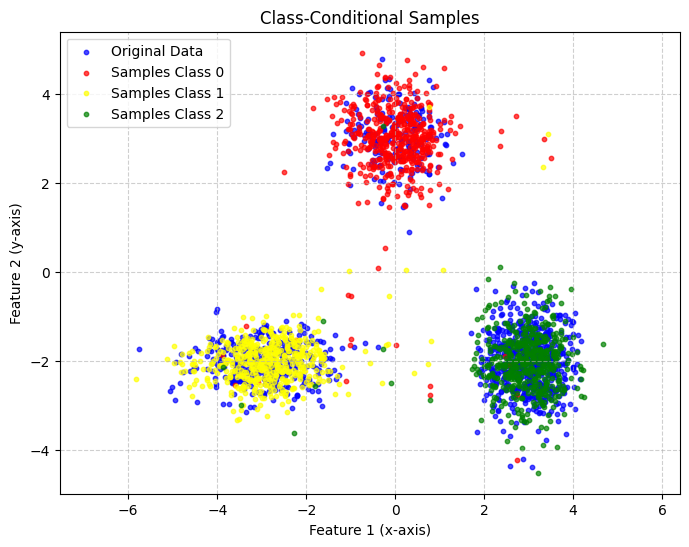

In [14]:
from spflow.meta.dispatch import SamplingContext

n_samples = 500
out_features = rat.out_features
num_features = 2

evidence = torch.full((n_samples, num_features), torch.nan)
channel_index = torch.full((n_samples, out_features), 0, dtype=torch.int64)
mask = torch.full((n_samples, out_features), True, dtype=torch.bool)
sampling_ctx = SamplingContext(channel_index=channel_index, mask=mask)
samples_class0 = sample(rat, evidence, sampling_ctx=sampling_ctx)

evidence = torch.full((n_samples, num_features), torch.nan)
channel_index = torch.full((n_samples, out_features), 1, dtype=torch.int64)
mask = torch.full((n_samples, out_features), True, dtype=torch.bool)
sampling_ctx = SamplingContext(channel_index=channel_index, mask=mask)
samples_class1 = sample(rat, evidence, sampling_ctx=sampling_ctx)

evidence = torch.full((n_samples, num_features), torch.nan)
channel_index = torch.full((n_samples, out_features), 2, dtype=torch.int64)
mask = torch.full((n_samples, out_features), True, dtype=torch.bool)
sampling_ctx = SamplingContext(channel_index=channel_index, mask=mask)
samples_class2 = sample(rat, evidence, sampling_ctx=sampling_ctx)
print(samples_class0.shape)
plot_scatter([data_np, samples_class0, samples_class1, samples_class2], title = 'Class-Conditional Samples', label_list=['Original Data', 'Samples Class 0', 'Samples Class 1', 'Samples Class 2'])

However, the model can of course also be used for classification. As an example, we visualize the trained decision boundaries of our model

torch.Size([90000, 1, 3])
tensor([[1],
        [1],
        [1],
        ...,
        [0],
        [0],
        [0]])


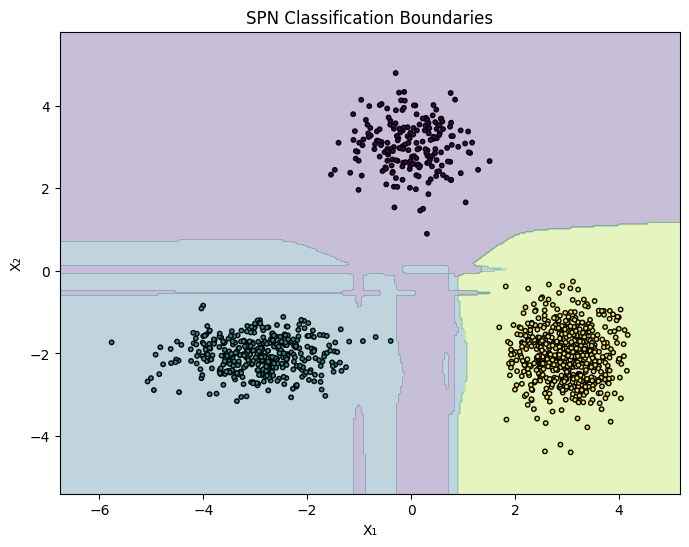

In [15]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# --- Assuming your dataset and labels are already created as above ---

# Let's assume you have an SPN model trained on this data:
# For example:
# spn = MySPNModel()
# spn.fit(dataset, labels)

# --- 1. Create a grid of points over the feature space ---
x_min, x_max = dataset[:, 0].min() - 1, dataset[:, 0].max() + 1
y_min, y_max = dataset[:, 1].min() - 1, dataset[:, 1].max() + 1

xx, yy = torch.meshgrid(
    torch.linspace(x_min, x_max, 300),
    torch.linspace(y_min, y_max, 300),
    indexing='xy'
)
grid_points = torch.stack([xx.flatten(), yy.flatten()], dim=1)

# --- 2. Get SPN predictions (probabilities or class scores) ---
# Example: if your SPN returns class probabilities
with torch.no_grad():
    probs = log_likelihood(rat.root_node.inputs, grid_points) # shape: [N_grid, num_classes]
    print(probs.shape)
    preds = probs.argmax(dim=-1)
    print(preds)

# --- 3. Reshape predictions to match the grid ---
Z = preds.reshape(xx.shape)

# --- 4. Plot decision boundaries ---
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, alpha=0.3, levels=len(means), cmap="viridis")

# Plot the original data
plt.scatter(dataset[:, 0], dataset[:, 1], c=labels, cmap="viridis", s=10, edgecolor="k")

plt.title("SPN Classification Boundaries")
plt.xlabel("X₁")
plt.ylabel("X₂")
plt.show()


## LearnSPN
Instead of creating a random structure, we can also train the SPN structure using the LearnSPN. 

In [16]:
from spflow.learn.learn_spn import learn_spn
scope = Scope(list(range(2)))
normal_layer = Normal(scope=scope, out_channels=4)
learn_spn = learn_spn(
    torch.tensor(dataset, dtype=torch.float32),
    leaf_modules=normal_layer,
    out_channels=1,
    min_instances_slice=70,
    min_features_slice = 2
)
learn_spn

used 3 iterations (0.006s) to cluster 1200 items into 2 clusters
used 2 iterations (0.002s) to cluster 798 items into 2 clusters


C:\Users\alex_\AppData\Local\Temp\ipykernel_7812\3209010222.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(dataset, dtype=torch.float32),
F:\Pycharm\PycharmProjects\SPFlowTorch\spflow\learn\learn_spn.py:366: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\TensorShape.cpp:3729.)
  weights = torch.tensor(w).T.unsqueeze(0).unsqueeze(-1)  # shape(1, num_clusters, 1)


Sum(
  D=1, C=1, R=None, weights=(1, 5, 1)
  (inputs): Cat(
    D=1, C=5, R=None, dim=2
    (inputs): ModuleList(
      (0): Sum(
        D=1, C=1, R=None, weights=(1, 8, 1)
        (inputs): Cat(
          D=1, C=8, R=None, dim=2
          (inputs): ModuleList(
            (0-1): 2 x Product(
              D=1, C=4, R=None
              (inputs): Cat(
                D=2, C=4, R=None, dim=1
                (inputs): ModuleList(
                  (0-1): 2 x Normal(
                    D=1, C=4, R=None
                    (distribution): Normal()
                  )
                )
              )
            )
          )
        )
      )
      (1): Product(
        D=1, C=4, R=None
        (inputs): Cat(
          D=2, C=4, R=None, dim=1
          (inputs): ModuleList(
            (0-1): 2 x Normal(
              D=1, C=4, R=None
              (distribution): Normal()
            )
          )
        )
      )
    )
  )
)

The trained SPN can now be used just like any other module

2
(1200, 2)
Original Data
2
torch.Size([1500, 2])
Samples


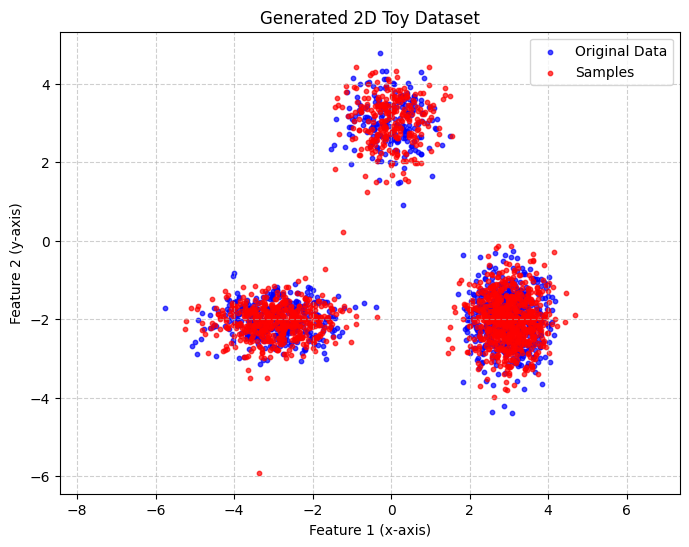

In [17]:
learn_spn_samples = sample(spn, 1500)

plot_scatter([data_np,samples], title= 'Generated 2D Toy Dataset', label_list=['Original Data', 'Samples'])

## Advanced Queries

To showcase more advanced queries like conditional sampling and MPE (Most Probable Explanation) we take a look at a dataset with more features.
Below, we load the digits dataset. This dataset contains 1797 8x8 images of digits 0 to 9.

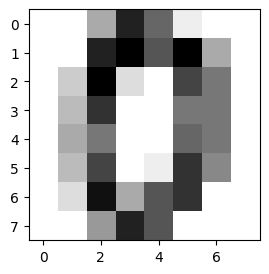

torch.Size([1797, 64])
tensor(0., dtype=torch.float32) tensor(16., dtype=torch.float32)


In [18]:
import matplotlib.pyplot as plt

from sklearn import datasets

# Load the digits dataset
digits = datasets.load_digits()

# Display the last digit
plt.figure(1, figsize=(3, 3))
plt.imshow(digits.images[0], cmap=plt.cm.gray_r, interpolation="nearest")
plt.show()

X = digits.data  # shape (1797, 64)
y = digits.target  # shape (1797,)

X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)

dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

print(X_tensor.shape)
print(X_tensor.min(), X_tensor.max())

Again we create a Rat SPN, but this time we use a Binomial distribution for the leaf layer. 

In [19]:
from spflow.modules.leaf import Binomial

depth = 3
n_region_nodes = 5
num_leaves = 5
num_repetitions = 2
n_root_nodes = 1
num_feature = 64
n = torch.tensor(16) # total count for binomial distribution

scope = Scope(list(range(0, num_feature)))

rat_leaf_layer = Binomial(scope=scope, n=n, out_channels=num_leaves, num_repetitions=num_repetitions)
rat = RatSPN(
    leaf_modules=[rat_leaf_layer],
    n_root_nodes=n_root_nodes,
    n_region_nodes=n_region_nodes,
    num_repetitions=num_repetitions,
    depth=depth,
    outer_product=True,
    split_halves=True,
)
rat

RatSPN(
  D=1, C=1, R=2
  (root_node): MixingLayer(
    D=1, C=1, R=2, weights=(1, 2, 1)
    (inputs): Sum(
      D=1, C=1, R=2, weights=(1, 25, 1, 2)
      (inputs): OuterProduct(
        D=1, C=25, R=2
        (inputs): ModuleList(
          (0): SplitHalves(
            D=2, C=5, R=2, dim=1
            (inputs): ModuleList(
              (0): Sum(
                D=2, C=5, R=2, weights=(2, 25, 5, 2)
                (inputs): OuterProduct(
                  D=2, C=25, R=2
                  (inputs): ModuleList(
                    (0): SplitHalves(
                      D=4, C=5, R=2, dim=1
                      (inputs): ModuleList(
                        (0): Sum(
                          D=4, C=5, R=2, weights=(4, 25, 5, 2)
                          (inputs): OuterProduct(
                            D=4, C=25, R=2
                            (inputs): ModuleList(
                              (0): SplitHalves(
                                D=8, C=5, R=2, dim=1
               

In [20]:
train_gradient_descent(rat, dataloader, epochs=20, lr=0.1)

Time taken for epoch:  0.32400012016296387
Time taken for epoch:  0.28099870681762695
Time taken for epoch:  0.28100085258483887
Time taken for epoch:  0.28499555587768555
Time taken for epoch:  0.31295228004455566
Time taken for epoch:  0.2939949035644531
Time taken for epoch:  0.28600001335144043
Time taken for epoch:  0.3050041198730469
Time taken for epoch:  0.29836177825927734
Time taken for epoch:  0.26200127601623535
Time taken for epoch:  0.26000046730041504
Time taken for epoch:  0.24899697303771973
Time taken for epoch:  0.24100136756896973
Time taken for epoch:  0.2409987449645996
Time taken for epoch:  0.22800350189208984
Time taken for epoch:  0.22699785232543945
Time taken for epoch:  0.2279982566833496
Time taken for epoch:  0.22000360488891602
Time taken for epoch:  0.21599555015563965
Time taken for epoch:  0.20700311660766602


Below is a visualization of some samples drawn from the Spn

Repetition idx: torch.Size([5, 1])
Samples shape before gather: torch.Size([5, 64, 5, 2])
torch.Size([5, 64])


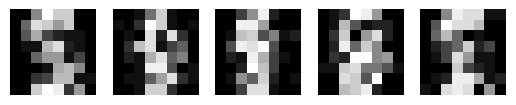

In [21]:
samples = sample(rat, 5)
print(samples.shape)

for i in range(5):
    img = samples[i].reshape(8, 8)  # reshape back to 2D
    plt.subplot(1, 5, i + 1)
    plt.imshow(img, cmap="gray")
    plt.axis("off")
plt.show()

Now can show some more advanced queries. One of them is getting the MPE. It returns the most probable state of the probabilistic circuit. This is often helpful to generate more clear samples and a good indicator whether the model could learn the data or not, which is not always evident with regular samples.

Repetition idx: torch.Size([1])
Samples shape before gather: torch.Size([1, 64, 5, 2])


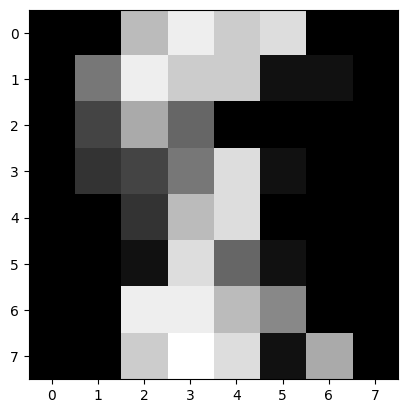

In [22]:
mpe = sample(rat,1, is_mpe=True)
plt.imshow(mpe.reshape(8,8), cmap="gray")
plt.show()

And at last we want to sample, given some evidence. In this example, the lower half of the image is given, and we want to sample the upper half given the lower half. 
This time, instead of explicitly defining a sampling context, we use the sample_with_evidence method. The method allows the user to just input the evidence and let the library internally handle the creation of the sampling context. This becomes handy if you have evidence but not multiple channel to sample from.

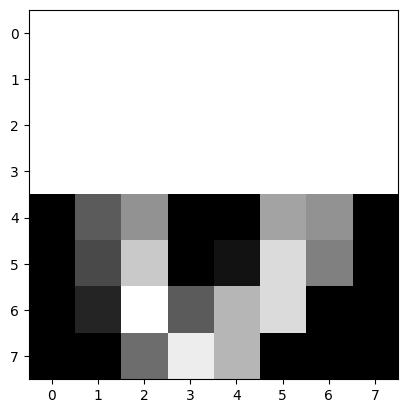

torch.Size([1, 64])
Repetition idx: torch.Size([1, 1, 1])
Samples shape before gather: torch.Size([1, 64, 5, 2])


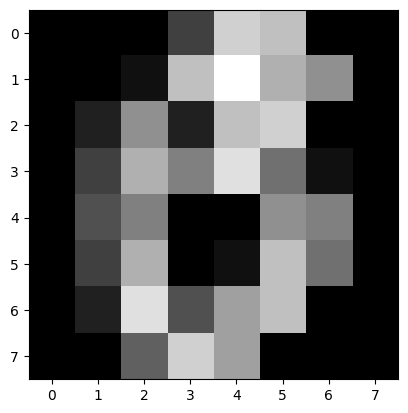

In [23]:
from spflow import sample_with_evidence
evidence = X_tensor[0]
evidence[:32] = torch.nan
plt.imshow(evidence.reshape(8,8), cmap="gray")
plt.show()
evidence = evidence.unsqueeze(0)
print(evidence.shape)
samples = sample_with_evidence(rat, evidence)
plt.imshow(samples.reshape(8,8), cmap="gray")
plt.show()
